In [1]:
def clearall():
    all = [var for var in globals() if var[0] != "_"]
    for var in all:
        del globals()[var]
clearall()

# https://www.datacamp.com/community/tutorials/introduction-factor-analysis

In [2]:
############################
######## LIBRAIRIES ########
############################

import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn import preprocessing
from statsmodels.tsa.stattools import adfuller
from colorama import Fore, Back, Style
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import time
import numpy as np
%matplotlib inline
plt.style.use('seaborn')

In [3]:
############################
######## FONCTIONS ########
###########################
def ols(model,results,residuals):
    jb = sm.stats.stattools.jarque_bera(residuals)[0]
    p_value = sm.stats.stattools.jarque_bera(residuals)[1]
    skew = round(sm.stats.stattools.robust_skewness(residuals)[0],4)
    kurtosis = round(sm.stats.stattools.robust_kurtosis(residuals)[0],4)
    print (name+' : ',results.summary())
    durbinwatson = sm.stats.stattools.durbin_watson(residuals, axis=0)
    print (name+' : ',durbinwatson)
    return(jb,p_value,skew,kurtosis,durbinwatson)

def ols_diff(diff):
    model_diff = sm.OLS(diff[1:],df.index[1:])
    results_diff = model_diff.fit()
    residuals_diff = results_diff.resid
    summary_diff = results_diff.summary()

    jb_diff = sm.stats.stattools.jarque_bera(residuals_diff)[0]
    p_value_diff = sm.stats.stattools.jarque_bera(residuals_diff)[1]
    skew_diff = round(sm.stats.stattools.robust_skewness(residuals_diff)[0],4)
    kurtosis_diff = round(sm.stats.stattools.robust_kurtosis(residuals_diff)[0],4)
    print (name+' : ',results_diff.summary())
    durbinwatson_diff = sm.stats.stattools.durbin_watson(residuals_diff, axis=0)
    print (name+' : ',durbinwatson_diff)
    return(jb_diff,p_value_diff,skew_diff,kurtosis_diff,durbinwatson_diff)

def jarque_berra(df):
    print(Fore.LIGHTBLUE_EX,'\nTEST DE NORMALITE : JARQUE-BERA '+name,Style.RESET_ALL)
    if p_value <= 0.05:
        print("Puisque la p-value (",round(p_value,4),") de la statistique de Jarque-Bera est inférieure au seuil de signification de 5%, donc on ",\
        "refuse l’hypothèse de la normalité de la série ")
        print(Fore.GREEN,'TEST JARQUE-BERRA VALIDE',Style.RESET_ALL)
    else:
        print("Puisque la p-value (",round(p_value,4),") de la statistique de Jarque-Bera est supérieure au seuil de signification de 5%",\
        " donc on refusel’hypothèse de la normalité de la série ")
        print(Fore.RED,"TEST JARQUE-BERA ECHOUE",Style.RESET_ALL)
    return()

def skewness(df):
    print(Fore.LIGHTBLUE_EX,"\nTEST D'ASSYMETRIE: SKEWNESS "+name,Style.RESET_ALL)
    if skew < -0.1 or skew > 0.1:
        print("Puisque le skewness (",round(skew,4),") de la statistiqest éloigné de 0, donc on valide en niveau 1 une distribution NON NORMALE")
        print(Fore.GREEN,'TEST SKEWNESS VALIDE',Style.RESET_ALL)
    else:
        print(Fore.RED,'/!\ ATTENTION SUPISCION DE NORMALITE /!\ ')
        print(Fore.RED,"TEST SKEWNESS ECHOUE",Style.RESET_ALL)
    return()

def kurtos(df):
    print(Fore.LIGHTBLUE_EX,"\nTEST D'ASSYMETRIE: KURTOSIS "+name,Style.RESET_ALL)
    if kurtosis > -3.1 or kurtosis < 3.1:
        print("Puisque le skewness (",round(kurtosis,4),") de la statistiqest éloigné de 3, donc on valide en niveau 2 une distribution NON NORMALE")
        print(Fore.GREEN,'TEST DE KURTOSIS VALIDE',Style.RESET_ALL)
    else:
        print(Fore.RED,'/!\ ATTENTION SUPISCION DE NORMALITE /!\ ')
        print(Fore.RED,"TEST KURTOSIS ECHOUE",Style.RESET_ALL)
    return()
def autocor(df):
    print(Fore.LIGHTBLUE_EX,"\nCORRELOGRAMME D'AUTOCORRELATION DE LA PAIRE "+name,Style.RESET_ALL)
    plot_acf(df['Close'])
    plot_pacf(df['Close'], lags=50)
    autocorell = pd.DataFrame()
    autocorell['ACF'] = sm.tsa.stattools.acf(df['Close'],qstat=True,fft=False)[0]
    autocorell['PACF'] = sm.tsa.stattools.pacf(df['Close'])
    QSTAT = list(sm.tsa.stattools.acf(df['Close'],qstat=True,fft=False)[1])
    QSTAT.append(df.iloc[-1]['Close'])
    PROB = list(sm.tsa.stattools.acf(df['Close'],qstat=True,alpha=0.05,fft=False)[3])
    PROB.append(0.5)
    autocorell['QSTAT'] = QSTAT
    autocorell['PROB'] = PROB
    print(name+' : ',autocorell.head())
    index = 0
    for i in range(len(autocorell)-1):
        if autocorell.iloc[i]['PACF']>autocorell.iloc[i]['PROB']+0.1:
            index += 1
    if index >= 1:
        print("L'index de sortie de l'intervalle de confiance à 5% est de",index,". Il apparait donc clairement que la série n'est pas un bruit blanc")
        print(Fore.GREEN,'TEST AUTOCORRELATION VALIDE',Style.RESET_ALL)
    else:
        print("L'index de sortie de l'intervalle de confiance à 5% est de",index,". Nous ne pouvons pas déterminer que la série n'est pas un bruit blanc")
    return()

def autocor_diff(diff):
    print(Fore.LIGHTBLUE_EX,"\nCORRELOGRAMME D'AUTOCORRELATION DE LA PAIRE EUR/USD EN PREMIERE DIFFERENCE",Style.RESET_ALL)
    plot_acf(diff)
    plot_pacf(diff, lags=50)
    autocorell = pd.DataFrame()
    autocorell['ACF'] = sm.tsa.stattools.acf(diff,qstat=True,fft=False)[0]
    autocorell['PACF'] = sm.tsa.stattools.pacf(diff)
    QSTAT = list(sm.tsa.stattools.acf(diff,qstat=True)[1],fft=False)
    QSTAT.append(0)
    PROB = list(sm.tsa.stattools.acf(diff,qstat=True,alpha=0.05)[3],fft=False)
    PROB.append(0.5)
    autocorell['QSTAT'] = QSTAT
    autocorell['PROB'] = PROB
    print(name+' : ',autocorell.head())
    index = 0
    for i in range(len(autocorell)-1):
        if autocorell.iloc[i]['PACF']>autocorell.iloc[i]['PROB']+0.1:
            index += 1
    if index >= 1:
        print("L'index de sortie de l'intervalle de confiance à 5% est de",index,". Il apparait donc clairement que la série n'est pas un bruit blanc")
        print(Fore.GREEN,'TEST AUTOCORRELATION VALIDE',Style.RESET_ALL)
        print("D’après le corrélogramme de la série ‘EURUSD’ en différence première, nous constatons que la première bande associée à la fonction    d’auto-corrélation partielle sort significativement de l’intervalle de confiance représenté par les pointillés, donc nous retenons p = 1 comme nombre de retards pour les régressions des tests ADF")
        p = 1
    else:
        print("L'index de sortie de l'intervalle de confiance à 5% est de",index,". Nous ne pouvons pas déterminer que la série n'est pas un bruit blanc")
    return()

def test_stationarity(timeseries,lag):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(20,6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation for '+name)
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test pour la paire : '+name)
    dftest = adfuller(timeseries, autolag=None,maxlag=lag )#'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    return(dfoutput)

def test_adf(df):
    print(Fore.BLUE,"\nADF MODELE 3 pour la paire : "+name,Style.RESET_ALL)
    X = df['Close'].values
    result_adf = adfuller(X)
    print('ADF Statistic: %f' % result_adf[0])
    print('p-value: %f' % result_adf[1])
    print('Critical Values:')

    for key, value in result_adf[4].items():
        print('\t%s: %.3f' % (key, value))

    if result_adf[1] >= 0.05:
        print("La p_value est de ",result_adf[1],"et est bien supérieure à 0.05. On accèpte l'hypothèse nulle Ho. Il n'y a pas de trend significatif")
        print(Fore.GREEN,'TEST ADF => NON STATIONNAIRE',Style.RESET_ALL)

    else:
        print(Fore.RED,"TEST ADF => STATIONNAIRE",Style.RESET_ALL)

    print(Fore.BLUE,"\nADF MODELE 2 (LAG)",Style.RESET_ALL)
    X = diff[1:].values
    result_adf = adfuller(X)
    print('ADF Statistic: %f' % result_adf[0])
    print('p-value: %f' % result_adf[1])
    print('Critical Values:')

    for key, value in result_adf[4].items():
        print('\t%s: %.3f' % (key, value))

    if result_adf[1] >= 0.05 :
        print(Fore.GREEN,'TEST ADF => NON STATIONNAIRE',Style.RESET_ALL)

    elif result_adf[0] >= min([result_adf[4]['1%'],result_adf[4]['5%'],result_adf[4]['10%']]):
        print(Fore.GREEN,'TEST ADF => NON STATIONNAIRE',Style.RESET_ALL)

    else:
        print("La série est stationnaire en intégration d'ordre 1")
        print(Fore.RED,"TEST ADF => STATIONNAIRE",Style.RESET_ALL)
    return()

def isname(pair):
    if pair.equals(eurusd):
        name = 'EUR/USD'
    elif pair.equals(audusd):
        name = 'AUD/USD'
    elif pair.equals(chfusd):
        name = 'CHF/USD'
    elif pair.equals(gbpusd):
        name = 'GBP/USD'
    elif pair.equals(jpyusd):
        name = 'JPY/USD'
    
    return(name)

def revname(name):
    if name == 'EUR/USD':
        pair = eurusd
    elif name == 'AUD/USD':
        pair = audusd
    elif name == 'CHF/USD':
        pair = chfusd
    elif name == 'GBP/USD':
        pair = gbpusd
    elif name == 'JPY/USD':
        pair = jpyusd
        
    return(pair)

def transform(df):
    df.iloc[:,1:5] = 1 / df.iloc[:,1:5]
    return(df)

In [4]:
base_eurusd = pd.read_csv('EURUSD.csv')

try:
    base_eurusd = base_eurusd.drop(['Unnamed: 0'],axis=1)
except:
    pass

base_audusd = pd.read_csv('AUDUSD.csv')

try:
    base_audusd = base_audusd.drop(['Unnamed: 0'],axis=1)
except:
    pass

base_chfusd = pd.read_csv('USDCHF.csv')
base_chfusd = transform(base_chfusd)
try:
    base_chfusd = base_chfusd.drop(['Unnamed: 0'],axis=1)
    
except:
    pass

base_gbpusd = pd.read_csv('GBPUSD.csv')

try:
    base_gbpusd = base_gbpusd.drop(['Unnamed: 0'],axis=1)
except:
    pass

base_jpyusd = pd.read_csv('USDJPY.csv')
base_jpyusd = transform(base_jpyusd)

try:
    base_jpyusd = base_jpyusd.drop(['Unnamed: 0'],axis=1)
except:
    pass



print('Vérification des longueur de bases (',base_eurusd.shape[0],') :')

if base_eurusd.shape[0] != base_audusd.shape[0] or base_eurusd.shape[0] != base_chfusd.shape[0] \
or base_eurusd.shape[0] != base_gbpusd.shape[0] or base_eurusd.shape[0] != base_jpyusd.shape[0] :
    print(Fore.RED,'=================== > NON VALIDE')

else:
    print(Fore.GREEN,'========================= > VALIDE',Style.RESET_ALL)

debut = base_eurusd.iloc[0]['Local time']
fin = base_eurusd.iloc[-1]['Local time']

print('\nPremière date : ',debut,['Local time'])
print('\nDernière date : ',fin,['Local time'],'\n')

début = input('Entrez la valeur du début (JJ.MM.AAAA HH:MM:SS) : ')
split = input('Entrez la valeur du split (JJ.MM.AAAA HH:MM:SS) : ')
fin = input('Entrez la valeur de la fin (JJ.MM.AAAA HH:MM:SS) : ')

eurusd = base_eurusd[(base_eurusd['Local time'] >= debut)&(base_eurusd['Local time'] < split)]
audusd = base_audusd[(base_audusd['Local time'] >= debut)&(base_audusd['Local time'] < split)]
chfusd = base_chfusd[(base_chfusd['Local time'] >= debut)&(base_chfusd['Local time'] < split)]
gbpusd = base_gbpusd[(base_gbpusd['Local time'] >= debut)&(base_gbpusd['Local time'] < split)]
jpyusd = base_jpyusd[(base_jpyusd['Local time'] >= debut)&(base_jpyusd['Local time'] < split)]

bt_eurusd = base_eurusd[(base_eurusd['Local time'] >= split)&(base_eurusd['Local time'] <= fin)]
bt_audusd = base_audusd[(base_audusd['Local time'] >= split)&(base_audusd['Local time'] <= fin)]
bt_chfusd = base_chfusd[(base_chfusd['Local time'] >= split)&(base_chfusd['Local time'] <= fin)]
bt_gbpusd = base_gbpusd[(base_gbpusd['Local time'] >= split)&(base_gbpusd['Local time'] <= fin)]
bt_jpyusd = base_jpyusd[(base_jpyusd['Local time'] >= split)&(base_jpyusd['Local time'] <= fin)]

PAIR = [eurusd,audusd,chfusd,gbpusd,jpyusd]
bt_PAIR = [bt_eurusd,bt_audusd,bt_chfusd,bt_gbpusd,bt_jpyusd]

Vérification des longueur de bases ( 2256 ) :
 ========================= > VALIDE 

Première date :  17.02.2020 00:00:00.000 GMT+0100 ['Local time']

Dernière date :  26.02.2020 19:55:00.000 GMT+0100 ['Local time'] 



Entrez la valeur du début (JJ.MM.AAAA HH:MM:SS) :  18.02.2020 00:00:00
Entrez la valeur du split (JJ.MM.AAAA HH:MM:SS) :  26.02.2020 08:55:00
Entrez la valeur de la fin (JJ.MM.AAAA HH:MM:SS) :  28.02.2020 11:55:00


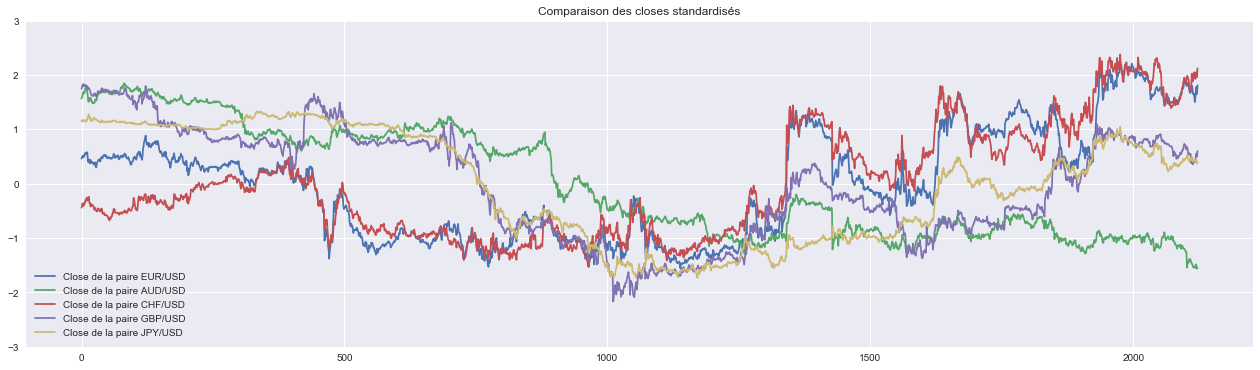

In [6]:
plt.figure(figsize=(22,6))

for pair in PAIR:
    name = isname(pair)

    #plt.figure(figsize=(16,4))
    plt.ylim(-3, 3)
    plt.title(label='Comparaison des closes standardisés')
    plt.plot(preprocessing.scale(pair['Close']),label='Close de la paire '+name,)
    plt.legend()

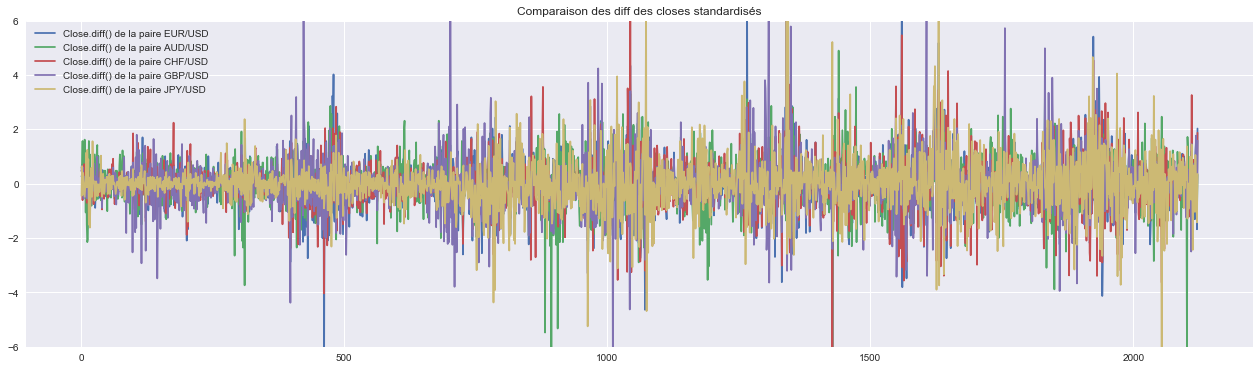

In [7]:
plt.figure(figsize=(22,6))

for pair in PAIR:
    name = isname(pair)

    #plt.figure(figsize=(16,4))
    plt.ylim(-6, 6)
    plt.title(label='Comparaison des diff des closes standardisés')
    plt.plot(preprocessing.scale(pair['Close'].diff()),label='Close.diff() de la paire '+name,)
    plt.legend()

EUR/USD :                                   OLS Regression Results                                
Dep. Variable:                  Close   R-squared (uncentered):                   0.751
Model:                            OLS   Adj. R-squared (uncentered):              0.751
Method:                 Least Squares   F-statistic:                              6392.
Date:                Fri, 28 Feb 2020   Prob (F-statistic):                        0.00
Time:                        13:10:23   Log-Likelihood:                         -1706.0
No. Observations:                2123   AIC:                                      3414.
Df Residuals:                    2122   BIC:                                      3420.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

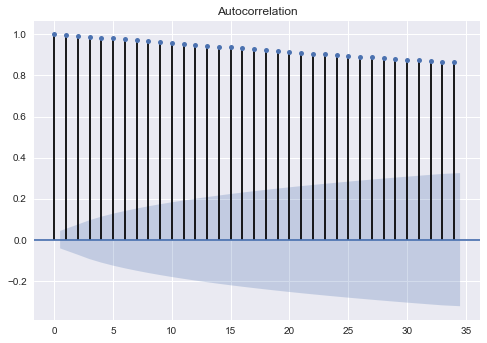

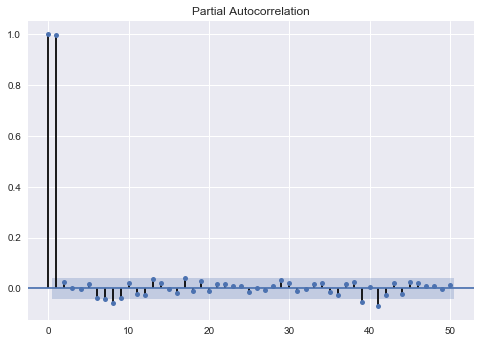

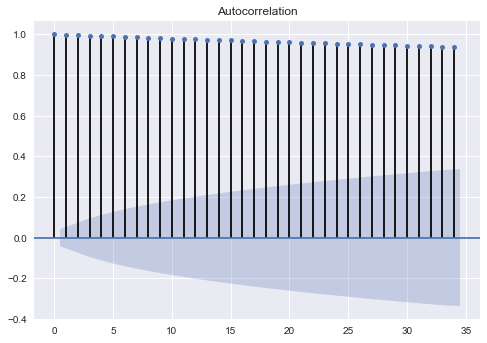

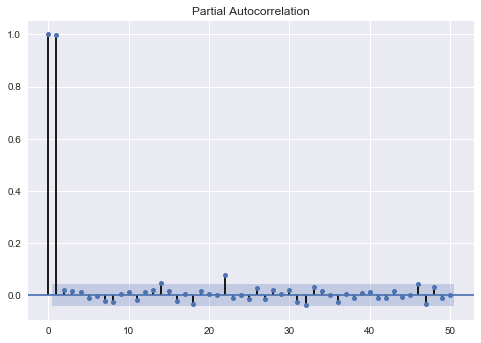

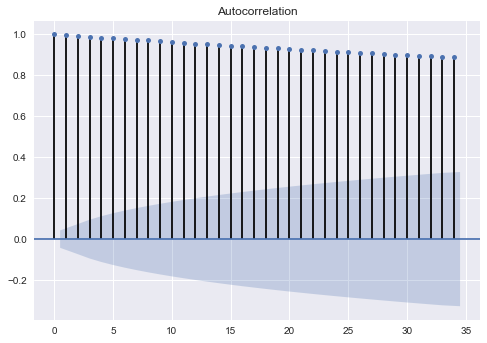

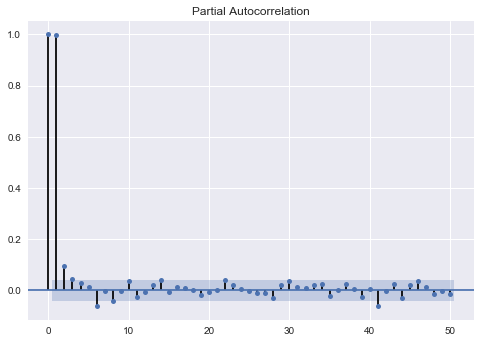

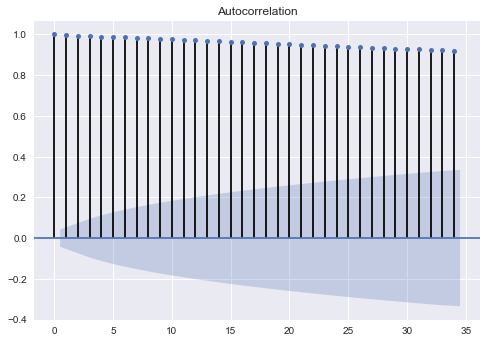

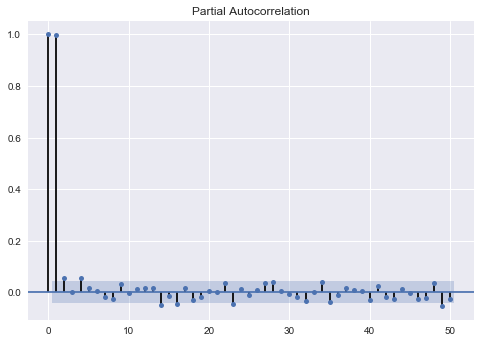

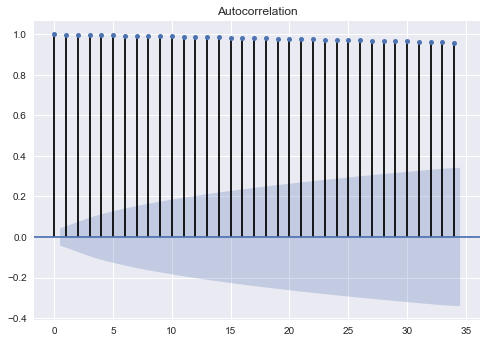

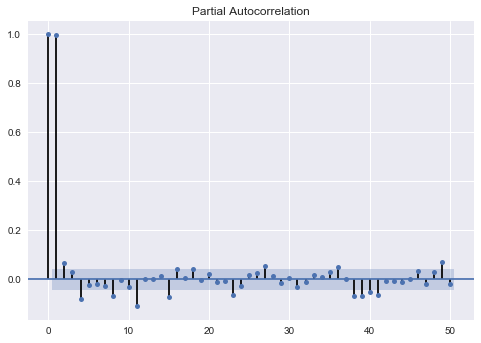

In [8]:
for pair in PAIR:
    
    name = isname(pair)
    
    model = sm.OLS(pair['Close'],pair.index)
    results = model.fit()
    residuals = results.resid
    summary = results.summary()

    jb,p_value,skew,kurtosis,durbinwatson = ols(model,results, residuals)
    
    print(Fore.YELLOW,'POUR LA PAIRE '+name,Style.RESET_ALL)
    jarque_berra(pair)
    skewness(pair)
    kurtos(pair)
    autocor(pair)
    

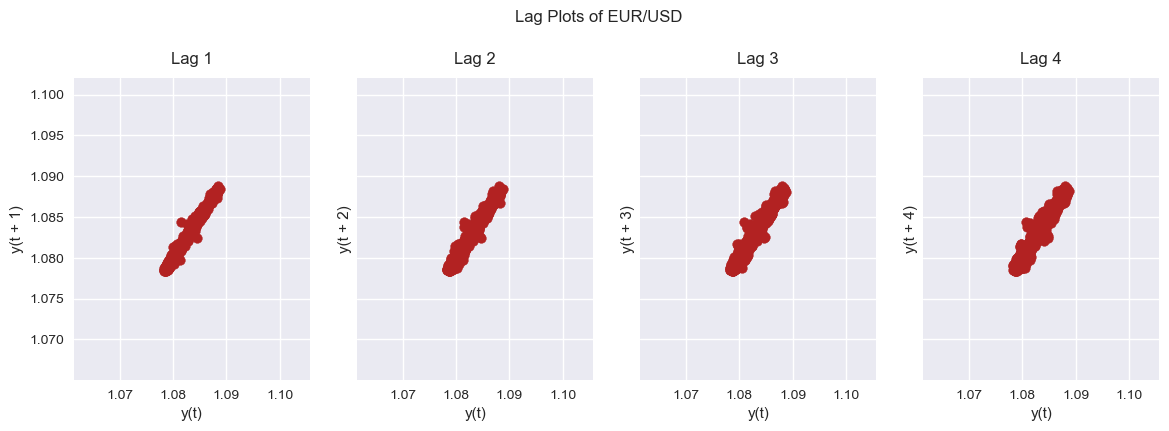

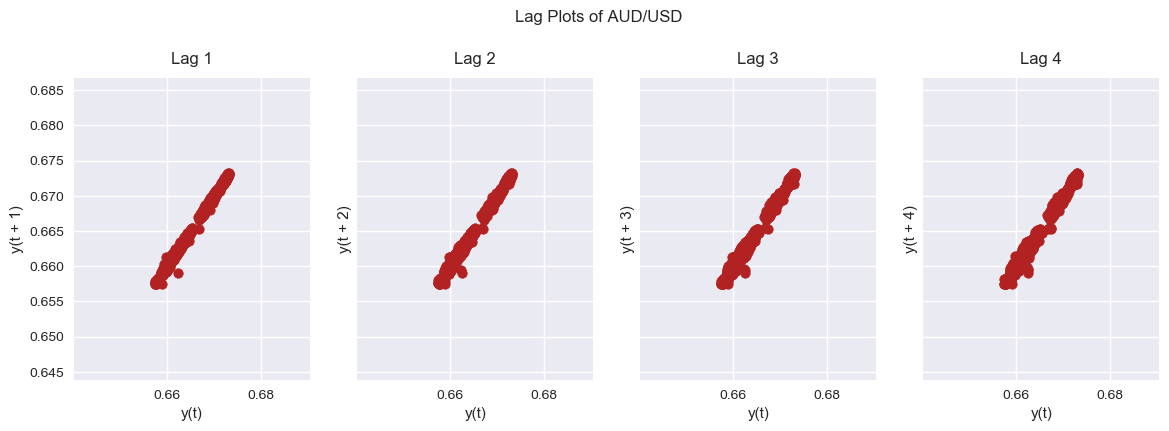

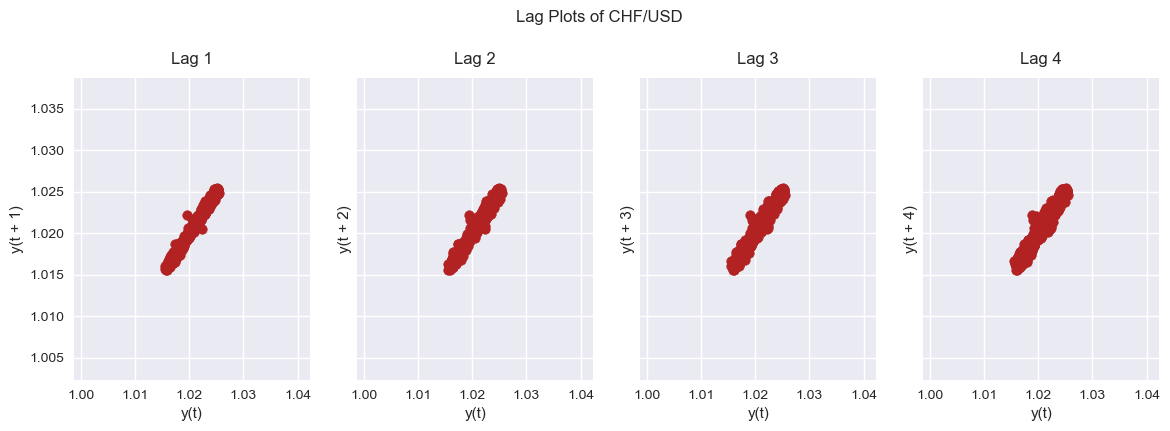

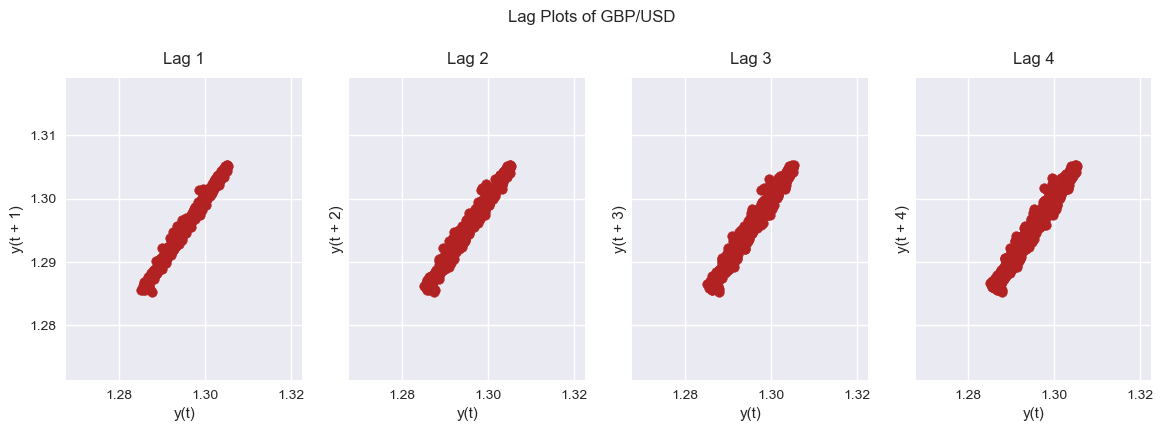

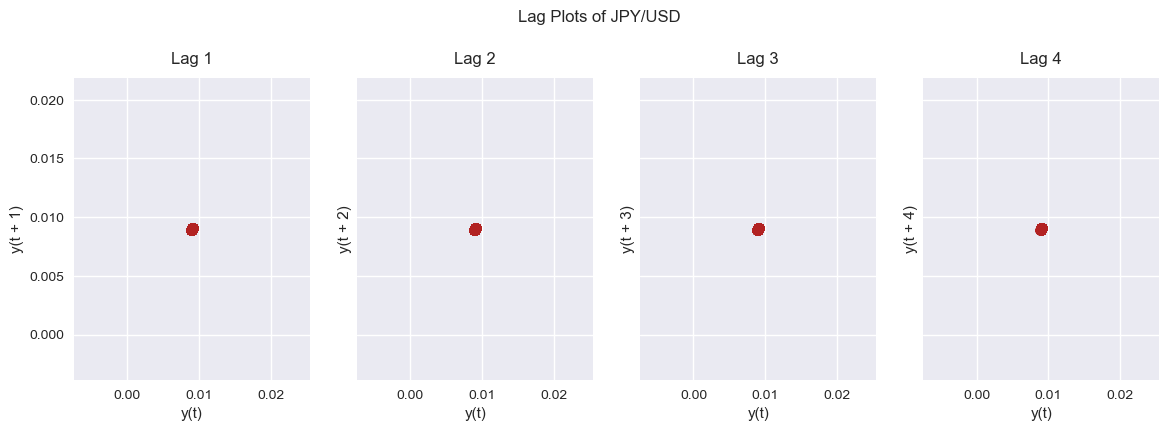

In [9]:
from pandas.plotting import lag_plot

for pair in PAIR:
    name = isname(pair)
    plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

    ss = pair[['Local time','Close']]
    #ss = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv')

    # Plot
    fig, axes = plt.subplots(1, 4, figsize=(14,4), sharex=True, sharey=True, dpi=100)
    for i, ax in enumerate(axes.flatten()):
        lag_plot(ss.Close, lag=i+1, ax=ax, c='firebrick')
        ax.set_title('Lag ' + str(i+1))

    fig.suptitle('Lag Plots of '+name+' Closes \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)    


    fig.suptitle('Lag Plots of '+name, y=1.05)    
    plt.show()

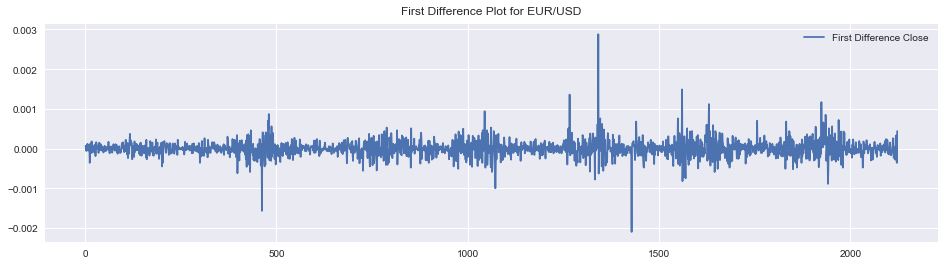

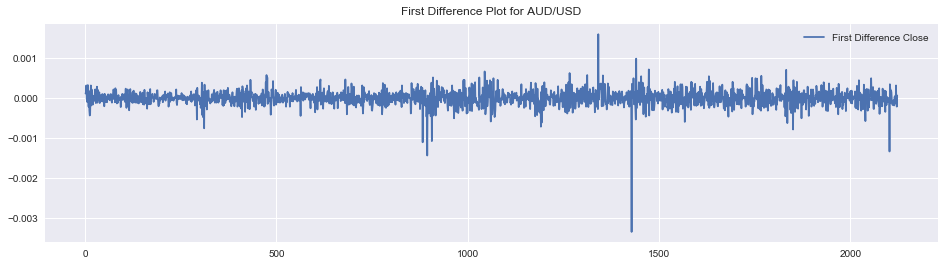

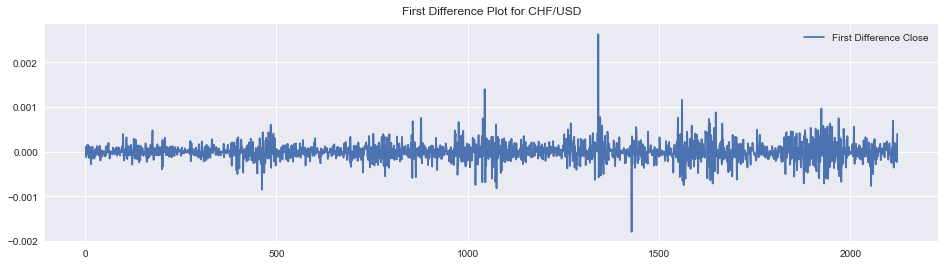

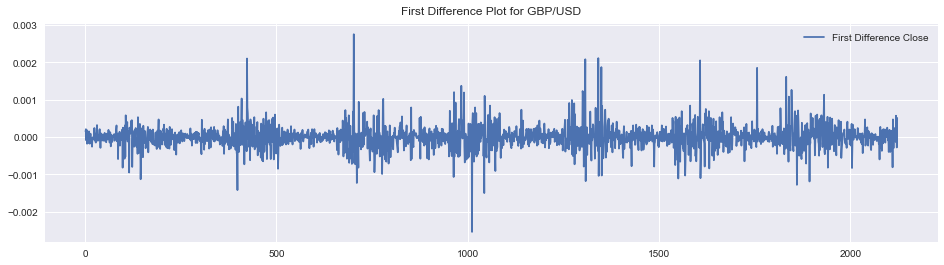

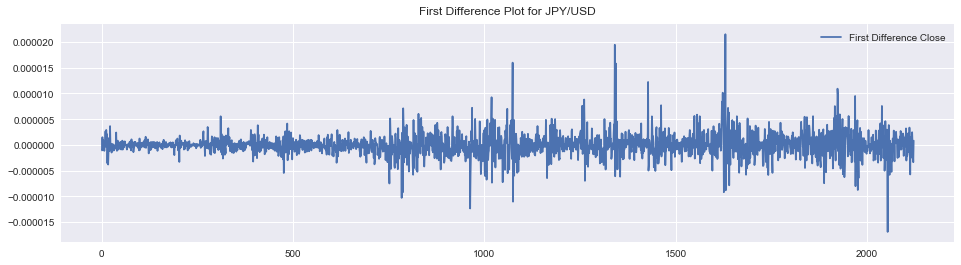

In [10]:
for pair in PAIR:
    name = isname(pair)
    diff = pair.Close.diff()
    plt.figure(figsize=(16,4))
    plt.plot(diff,label='First Difference Close')
    plt.title(label='First Difference Plot for '+name)
    plt.legend()



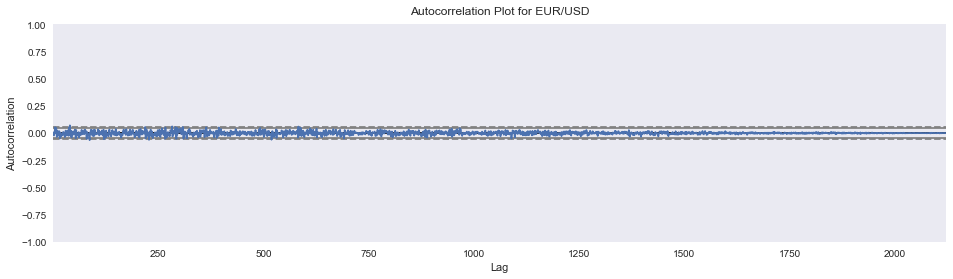

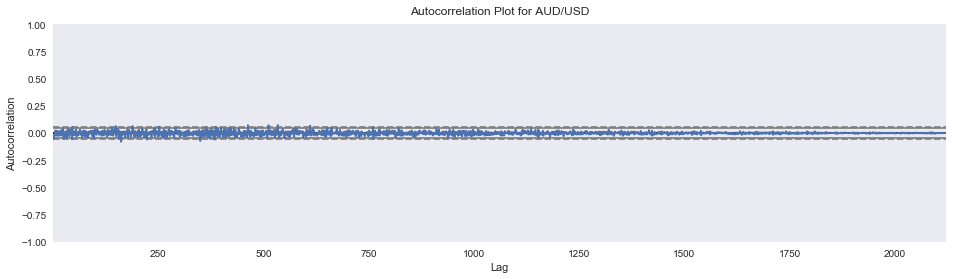

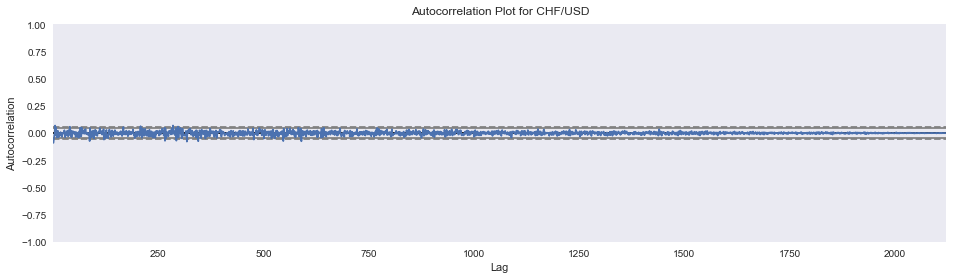

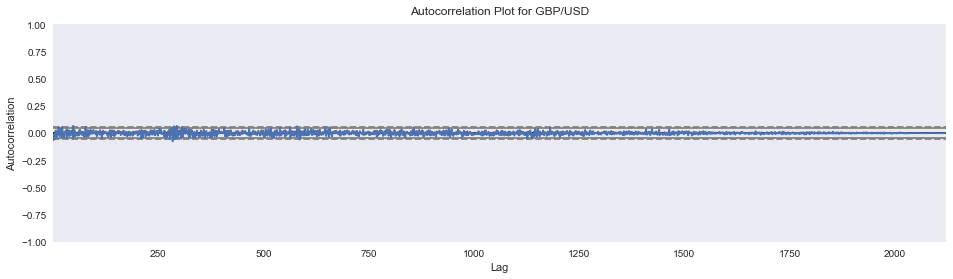

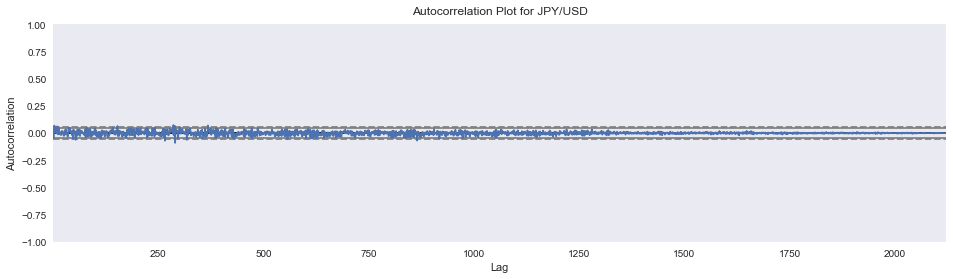

In [11]:
for pair in PAIR:
    name = isname(pair)
    diff = pair.Close.diff()
    plt.figure(figsize=(16,4))

    pd.plotting.autocorrelation_plot(diff[1:])
    plt.title(label='Autocorrelation Plot for '+name)
    

In [12]:
'''for pair in PAIR:
    name = isname(pair)
    timeseries = pair['Close']
    timeseries.index = pair['Local time']
    test_stationarity(timeseries)'''

"for pair in PAIR:\n    name = isname(pair)\n    timeseries = pair['Close']\n    timeseries.index = pair['Local time']\n    test_stationarity(timeseries)"

In [13]:
df = pd.DataFrame()
for pair in PAIR:
    name = isname(pair)
    df[name] = list(pair['Close'])
df.corr().style.background_gradient(cmap='coolwarm')

,EUR/USD,AUD/USD,CHF/USD,GBP/USD,JPY/USD
EUR/USD,1.000000,-0.207513,0.916738,0.417286,0.380954
AUD/USD,-0.207513,1.000000,-0.478429,0.624238,0.633988
CHF/USD,0.916738,-0.478429,1.000000,0.241672,0.213418
GBP/USD,0.417286,0.624238,0.241672,1.000000,0.893495
JPY/USD,0.380954,0.633988,0.213418,0.893495,1.000000


In [14]:
INTEGRE = []
for col in range(1,len(df.corr())):
    for ind in range(col):
        if df.corr().iloc[ind,col] > 0.5 and df.corr().iloc[ind,col] != 1:
            INTEGRE.append((df.corr().index[ind],df.corr().columns[col]))
        
INTEGRE  = list(set(INTEGRE))
print('Les paires ',INTEGRE,' sont correlées et permettent un factorisation.')

Les paires  [('AUD/USD', 'JPY/USD'), ('EUR/USD', 'CHF/USD'), ('AUD/USD', 'GBP/USD'), ('GBP/USD', 'JPY/USD')]  sont correlées et permettent un factorisation.


In [15]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(df)
print('Le KMO du modèle est de :',kmo_model)
for loop,pair in enumerate(PAIR):
    name = isname(pair)
    if kmo_all[loop] >= 0.6:
        print(Fore.GREEN,name,Style.RESET_ALL,' a un kmo considéré comme ',Fore.GREEN,'adéquet',Style.RESET_ALL)
    else:
        print(Fore.RED,name,Style.RESET_ALL,' a un kmo donsidéré comme ',Fore.RED,'inadéquat',Style.RESET_ALL)

Le KMO du modèle est de : 0.5535495976811398
 EUR/USD   a un kmo donsidéré comme   inadéquat 
 AUD/USD   a un kmo donsidéré comme   inadéquat 
 CHF/USD   a un kmo donsidéré comme   inadéquat 
 GBP/USD   a un kmo considéré comme   adéquet 
 JPY/USD   a un kmo considéré comme   adéquet 


/opt/anaconda3/envs/FinTech/lib/python3.7/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


In [16]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df)
print('Dans le test de Barlett, on ibserve un chi2 à ',chi_square_value,' et une p_value à', p_value)
if p_value < 0.05:
    print(Fore.GREEN,'Statistically significant',Style.RESET_ALL," ce qui signifie que la matrice de correlation observée n'est pas une identity matrix" )
else:
    print(Fore.RED,'Statistically non significant',Style.RESET_ALL," ce qui signifie que la matrice de correlation observée peut être une identity matrix" )

Dans le test de Barlett, on ibserve un chi2 à  12604.01607978478  et une p_value à 0.0
 Statistically significant   ce qui signifie que la matrice de correlation observée n'est pas une identity matrix


In [17]:
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer(rotation=None)
fa.fit(df)
print(fa.loadings_)
#fa.analyze(df, 25, rotation=None)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()

[[ 0.69485226  0.66225233  0.20031065]
 [ 0.44807703 -0.83983891  0.18633924]
 [ 0.53139969  0.84198492 -0.05048002]
 [ 0.89688786 -0.28430346 -0.08804728]
 [ 0.88418613 -0.31248761 -0.13219732]]


In [18]:
ev

array([2.63151157, 2.07051986, 0.16553375, 0.10467708, 0.02775775])

In [19]:
v

array([ 2.55216947e+00,  2.03132192e+00,  1.02622188e-01,  4.53756771e-06,
       -4.02176201e-07])

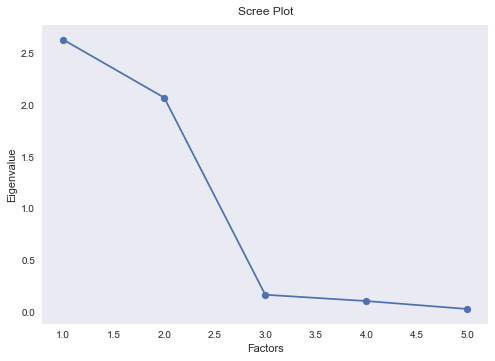

In [20]:
# Create scree plot using matplotlib
plt.scatter(range(1,df.shape[1]+1),ev)
plt.plot(range(1,df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [21]:
PRINCIPAL_COMPOSANT = []
for loop,pair in enumerate(PAIR):
    name = isname(pair)
    print('\r\n'+name+' : ',ev[loop]," ===> ",end='')
    if ev[loop] >= 1:
        print('On garde le facteur car >1')
        PRINCIPAL_COMPOSANT.append((name,ev[loop]))
    else:
        print('On retire le facteur car <1')

print('\nRésumé des composants principaux gardés :')        
PRINCIPAL_COMPOSANT        


EUR/USD :  2.6315115651947307  ===> On garde le facteur car >1

AUD/USD :  2.070519857024363  ===> On garde le facteur car >1

CHF/USD :  0.1655337494735234  ===> On retire le facteur car <1

GBP/USD :  0.10467708044328763  ===> On retire le facteur car <1

JPY/USD :  0.027757747864096134  ===> On retire le facteur car <1

Résumé des composants principaux gardés :


[('EUR/USD', 2.6315115651947307), ('AUD/USD', 2.070519857024363)]

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [23]:
x_pca = pca.transform(df)
x_pca.shape

(2123, 2)

Text(0, 0.5, 'Second Principal Component')

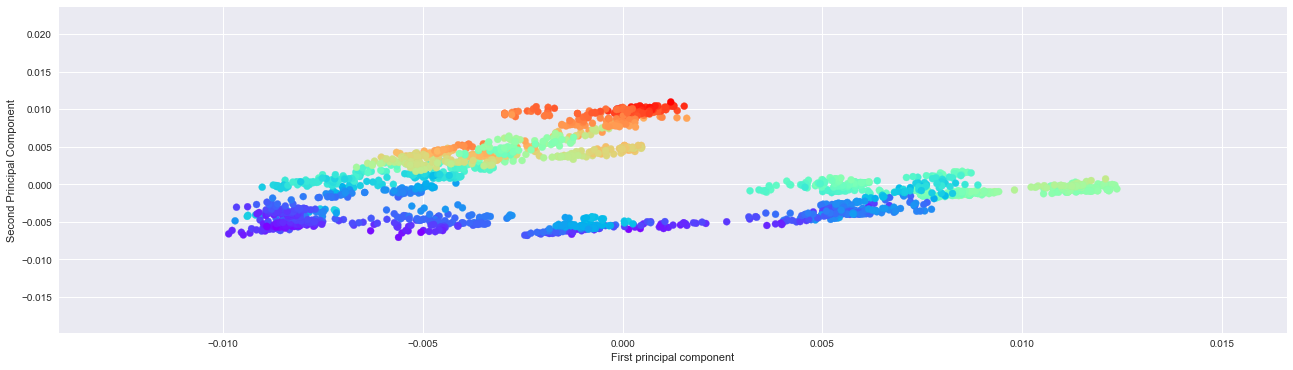

In [24]:
plt.figure(figsize=(22,6))
plt.scatter( x_pca[:,0],x_pca[:,1],c=df['EUR/USD'],cmap='rainbow')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

In [25]:
for loop,pair in enumerate(PAIR):
    name = isname(pair)
    print(name,' : ',pca.components_[0][loop],' - ',pca.components_[1][loop])
    

EUR/USD  :  0.07863826885286881  -  0.5630387086013265
AUD/USD  :  0.6517823178751974  -  -0.4797607184894446
CHF/USD  :  -0.0268016296092476  -  0.5581246009956337
GBP/USD  :  0.7537841322011529  -  0.37589721582690006
JPY/USD  :  0.009326707302267064  -  0.003908773220847521


In [26]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen as johasen
jh_results = johasen(df,0,1)
print('\nTrace Statistisque \n',jh_results.lr1)                           # dim = (n,) Trace statistic
print('\n\nCritical Value \n',jh_results.cvt)                           # dim = (n,3) critical value table (90%, 95%, 99%)
print('\n\nEigein Velue ec \n',jh_results.evec)                          # dim = (n, n), columnwise eigen-vectors
v1 = jh_results.evec[:, 0]
v2 = jh_results.evec[:, 1]
print('\n\nProbabilité de Eigein \n',jh_results.eig)
if jh_results.eig[0] <= 0.05:
    print('\nTest de cointiégration de Johasen ',Fore.GREEN,'VALIDE!',Style.RESET_ALL)
else:
    print('\nTest de cointiégration de Johasen',Fore.RED,'INVALIDE!',Style.RESET_ALL)


Trace Statistisque 
 [69.5343071  29.94126641 15.47803129  6.29579386  2.22170034]


Critical Value 
 [[65.8202 69.8189 77.8202]
 [44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


Eigein Velue ec 
 [[ 9.18580831e+02 -2.66066507e+00  8.32511544e+02 -2.53278269e+02
  -7.96543204e+01]
 [-4.95795941e+02 -2.50707168e+02  1.18812385e+02  2.76603083e+02
   7.98499545e+01]
 [-1.65807314e+03 -2.43911131e+02 -5.19723430e+02  2.59638456e+02
   5.69165489e+01]
 [ 2.26828585e+02 -2.89248173e+02 -2.68696866e+02 -2.12767414e+02
  -3.06695040e+01]
 [ 6.32970884e+03  3.17555619e+04  3.52444688e+03  8.47498872e+03
  -1.49936096e+04]]


Probabilité de Eigein 
 [0.01849401 0.00679587 0.00431984 0.00191899 0.00104693]

Test de cointiégration de Johasen   VALIDE! 


In [27]:
from sklearn.linear_model import LinearRegression

X = df.iloc[:,1:]
y = df.iloc[:,0]
reg = LinearRegression().fit(X, y)
score = reg.score(X, y) *100
coef = reg.coef_
cste = reg.intercept_

if score > 70:
    print('Test ',Fore.GREEN,'VALIDE',Style.RESET_ALL,' avec un score de ',Fore.GREEN,score,Style.RESET_ALL,' %')
    print("Les poids respectifs sont de :")
    loop = -1
    for pair in PAIR:
        name = isname(pair)
        if name == 'EUR/USD':
            continue
        loop += 1
        print(name,' : ',coef[loop])
    print('Et la constante est : ',cste)

elif score > 50:
    print('Test ',Fore.YELLOW,'MITIGE',Style.RESET_ALL,' avec un score de ',Fore.YELLOW,score,Style.RESET_ALL,' %')
    print("Les poids respectifs sont de :")
    loop = 0
    for pair in PAIR:
        name = isname(pair)
        if name == 'EUR/USD':
            continue
        loop += 1
        print(name,' : ',coef[loop])
    print('Et la constante est : ',cste)

else:
    print('Test ',Fore.RED,'NON VALIDE',Style.RESET_ALL,' avec un score de ',Fore.YELLOW,score,Style.RESET_ALL,' %')
    print("Les poids respectifs sont de :")
    loop = 0
    for pair in PAIR:
        name = isname(pair)
        if name == 'EUR/USD':
            continue
        loop += 1
        print(name,' : ',coef[loop])
    print('Et la constante est : ',cste)


Test   VALIDE   avec un score de   91.49086286643355   %
Les poids respectifs sont de :
AUD/USD  :  0.2661778860857056
CHF/USD  :  1.25485627161679
GBP/USD  :  -0.023870634584646885
JPY/USD  :  -4.77404405934131
Et la constante est :  -0.29960137192190484


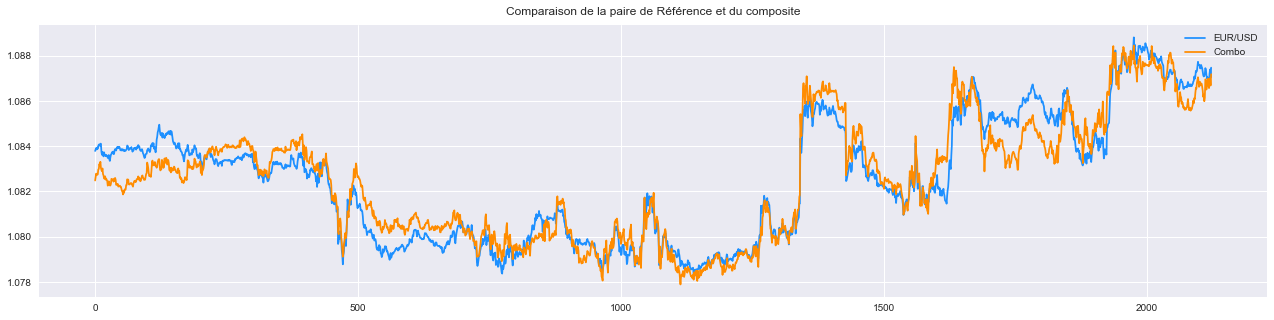

In [28]:
combo = cste + coef[0] * df['AUD/USD'] + coef[1] * df['CHF/USD'] + coef[2] * df['GBP/USD'] + coef[3] * df['JPY/USD']
plt.figure(figsize=(22,5))
plt.plot(df['EUR/USD'],label = 'EUR/USD',c='dodgerblue')
plt.plot(combo,label = 'Combo',c='darkorange')
plt.title('Comparaison de la paire de Référence et du composite')
plt.legend()

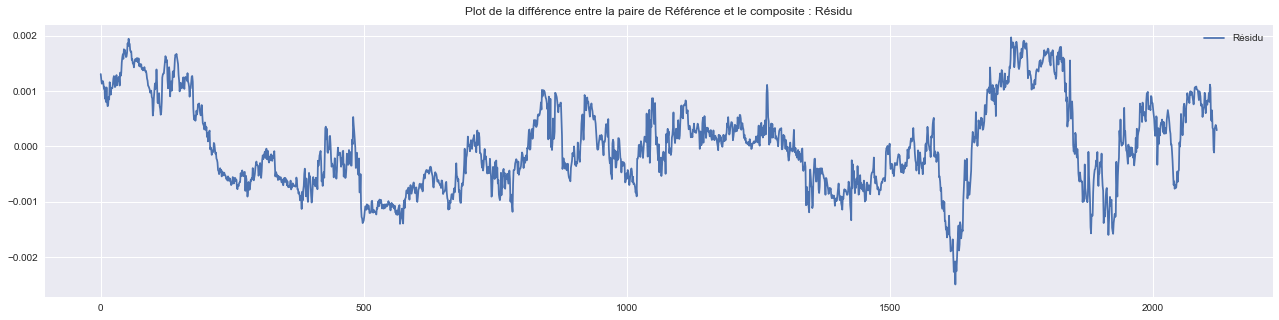

In [29]:
########
### RESIDUS
########
residu = df['EUR/USD']-combo
S = (residu - residu.mean())/residu.std()
plt.figure(figsize=(22,5))
plt.plot(residu,label = 'Résidu')
plt.title('Plot de la différence entre la paire de Référence et le composite : Résidu')
plt.legend()

 
TEST DE NORMALITE : JARQUE-BERA JPY/USD 
Puisque la p-value ( 0.0 ) de la statistique de Jarque-Bera est inférieure au seuil de signification de 5%, donc on  refuse l’hypothèse de la normalité de la série 
 TEST JARQUE-BERRA VALIDE 
 
TEST D'ASSYMETRIE: SKEWNESS JPY/USD 
 /!\ ATTENTION SUPISCION DE NORMALITE /!\ 
 TEST SKEWNESS ECHOUE 
 
TEST D'ASSYMETRIE: KURTOSIS JPY/USD 
Puisque le skewness ( -1.2165 ) de la statistiqest éloigné de 3, donc on valide en niveau 2 une distribution NON NORMALE
 TEST DE KURTOSIS VALIDE 
 
CORRELOGRAMME D'AUTOCORRELATION DE LA PAIRE JPY/USD 
JPY/USD :          ACF      PACF        QSTAT  PROB
0  1.000000  1.000000  2021.455929   0.0
1  0.975103  0.975562  3978.335797   0.0
2  0.959175  0.173121  5880.763843   0.0
3  0.945513  0.074555  7734.919576   0.0
4  0.933220  0.047285  9548.170264   0.0
L'index de sortie de l'intervalle de confiance à 5% est de 3 . Il apparait donc clairement que la série n'est pas un bruit blanc
 TEST AUTOCORRELATION VALIDE 
La 

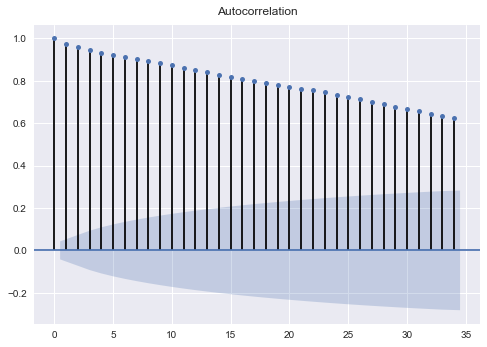

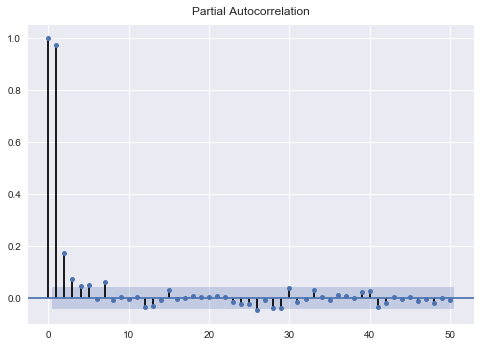

In [30]:
####
## ANALYSE DES RESIDUS
###

jarque_berra(residu)
skewness(residu)
kurtos(residu)
residu_autocor = pd.DataFrame()
residu_autocor['Close'] = residu.iloc[:]
autocor(residu_autocor)
print("La moyenne des résidus est de ",residu.mean(),", et leur ecart-type vaut ",residu.std())

In [31]:
model = sm.OLS(residu,residu.index)
results = model.fit()
residuals = results.resid
summary = results.summary()
name = 'Analyse des Résidus'
jb,p_value,skew,kurtosis,durbinwatson = ols(model,results, residuals)

Analyse des Résidus :                                   OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              1.206
Date:                Fri, 28 Feb 2020   Prob (F-statistic):                       0.272
Time:                        13:13:58   Log-Likelihood:                          12142.
No. Observations:                2123   AIC:                                 -2.428e+04
Df Residuals:                    2122   BIC:                                 -2.428e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

 
CORRELOGRAMME D'AUTOCORRELATION DE LA PAIRE Analyse des Résidus 
Analyse des Résidus :          ACF      PACF        QSTAT  PROB
0  1.000000  1.000000  2021.455929   0.0
1  0.975103  0.975562  3978.335797   0.0
2  0.959175  0.173121  5880.763843   0.0
3  0.945513  0.074555  7734.919576   0.0
4  0.933220  0.047285  9548.170264   0.0
L'index de sortie de l'intervalle de confiance à 5% est de 3 . Il apparait donc clairement que la série n'est pas un bruit blanc
 TEST AUTOCORRELATION VALIDE 


()

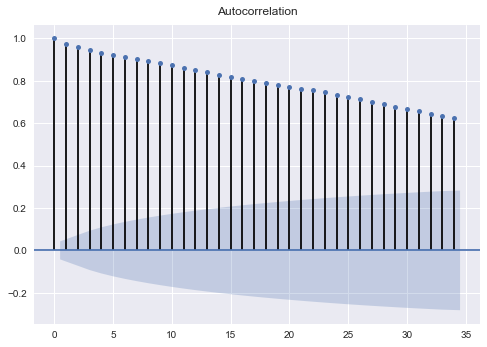

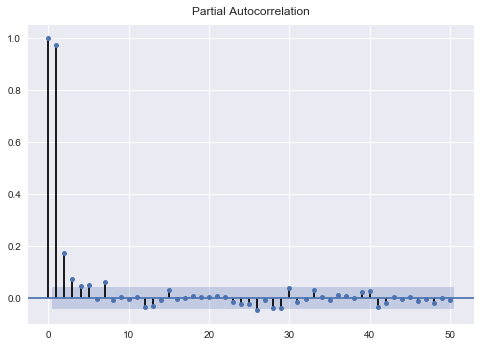

In [32]:
temp = pd.DataFrame()
temp['Close'] = residu.iloc[:]
autocor(temp)

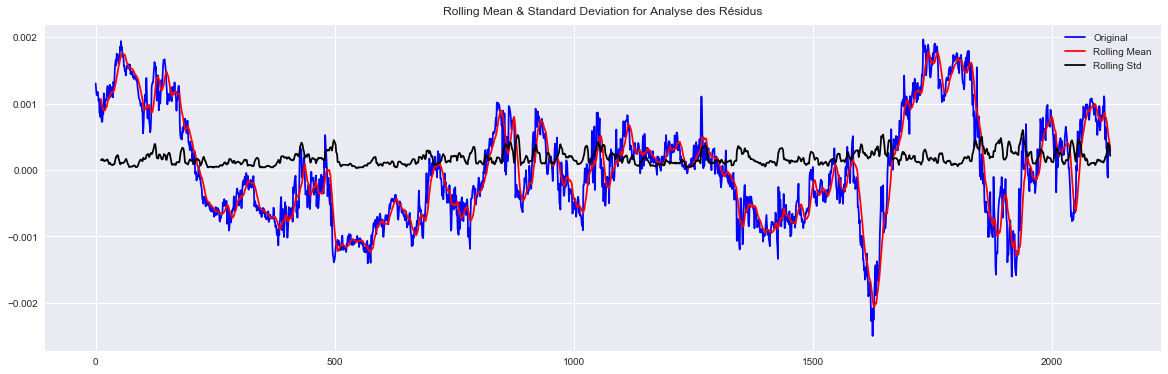

Results of Dickey-Fuller Test pour la paire : Analyse des Résidus
Test Statistic                   -4.387117
p-value                           0.000313
#Lags Used                        1.000000
Number of Observations Used    2121.000000
Critical Value (1%)              -3.433437
Critical Value (5%)              -2.862904
Critical Value (10%)             -2.567496
dtype: float64
Le test est   VALIDE  et le résidu est :   STATIONNAIRE 


In [33]:
dfoutput =  test_stationarity(residu,lag = 1)
if dfoutput[1] < 0.05 and dfoutput[0] < dfoutput[6]:
    print('Le test est ',Fore.GREEN,'VALIDE',Style.RESET_ALL,'et le résidu est : ',Fore.GREEN,'STATIONNAIRE',Style.RESET_ALL)
else:
    print('Le test est ',Fore.RED,'NON VALIDE',Style.RESET_ALL,'et le résidu  : ',Fore.RED,'NON STATIONNAIRE',Style.RESET_ALL)

   

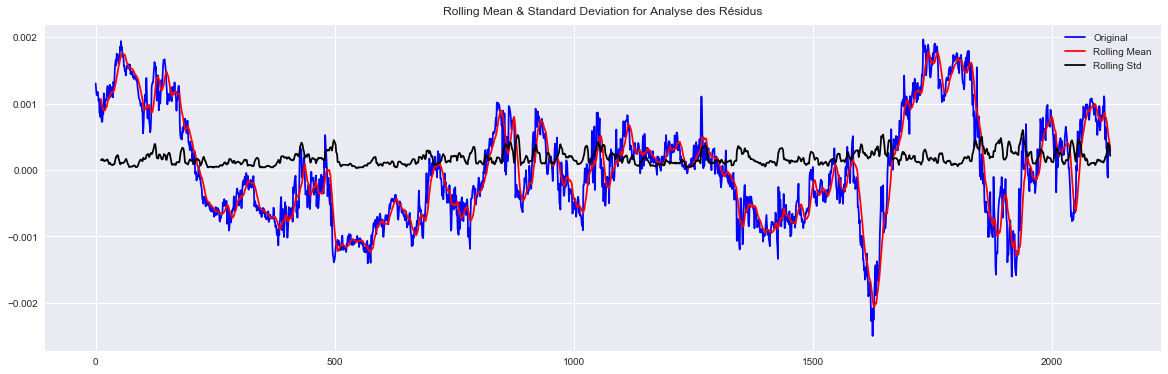

Results of Dickey-Fuller Test pour la paire : Analyse des Résidus
Test Statistic                   -5.227814
p-value                           0.000008
#Lags Used                        0.000000
Number of Observations Used    2122.000000
Critical Value (1%)              -3.433435
Critical Value (5%)              -2.862903
Critical Value (10%)             -2.567496
dtype: float64
Le test est   VALIDE  et il y a :   RETOUR A LA MOYENNE 


In [34]:
#######
### RETOUR A LA MOYENNE
#######
dfoutput =  test_stationarity(residu,lag = 0)
if dfoutput[1] < 0.05 and dfoutput[0] < dfoutput[6]:
    print('Le test est ',Fore.GREEN,'VALIDE',Style.RESET_ALL,'et il y a : ',Fore.GREEN,'RETOUR A LA MOYENNE',Style.RESET_ALL)
else:
    print('Le test est ',Fore.RED,'NON VALIDE',Style.RESET_ALL,"et il n'y a ",Fore.RED,'PAS RETOUR A LA MOYENNE',Style.RESET_ALL)


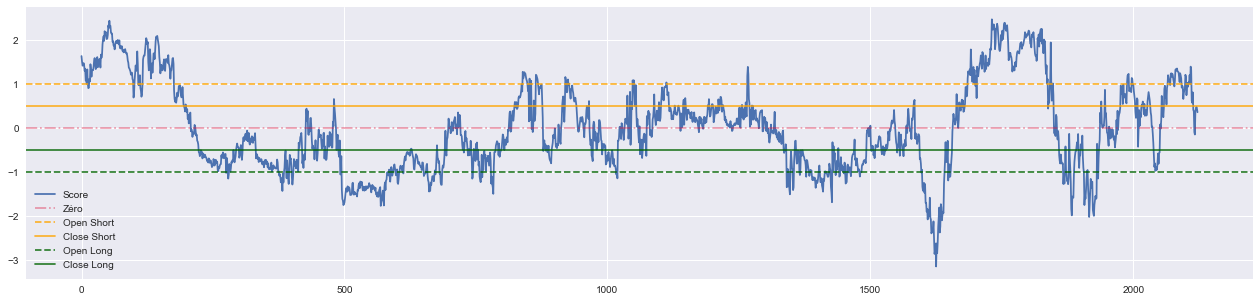

In [35]:
plt.figure(figsize=(22,5))
plt.plot(S,label='Score')
plt.axhline(y=0,c='crimson',alpha=0.4,linestyle='-.',label='Zéro')
plt.axhline(y=1,c='orange',alpha=0.8,linestyle='--',label='Open Short')
plt.axhline(y=0.5,c='orange',alpha=0.8,label ='Close Short')
plt.axhline(y=-1,c='darkgreen',alpha=0.8,linestyle='--', label='Open Long')
plt.axhline(y=-0.5,c='darkgreen',alpha=0.8,label='Close Long')
plt.legend()

In [36]:
########
### BT
#######



In [37]:
bt_df = pd.DataFrame()
for bt_pair in bt_PAIR:
    
    if bt_pair.equals(bt_eurusd):
        name = 'EUR/USD'
    elif bt_pair.equals(bt_audusd):
        name = 'AUD/USD'
    elif bt_pair.equals(bt_chfusd):
        name = 'CHF/USD'
    elif bt_pair.equals(bt_gbpusd):
        name = 'GBP/USD'
    elif bt_pair.equals(bt_jpyusd):
        name = 'JPY/USD'
    
    
    bt_df[name] = list(bt_pair['Close'])
df.corr().style.background_gradient(cmap='coolwarm')

,EUR/USD,AUD/USD,CHF/USD,GBP/USD,JPY/USD
EUR/USD,1.000000,-0.207513,0.916738,0.417286,0.380954
AUD/USD,-0.207513,1.000000,-0.478429,0.624238,0.633988
CHF/USD,0.916738,-0.478429,1.000000,0.241672,0.213418
GBP/USD,0.417286,0.624238,0.241672,1.000000,0.893495
JPY/USD,0.380954,0.633988,0.213418,0.893495,1.000000


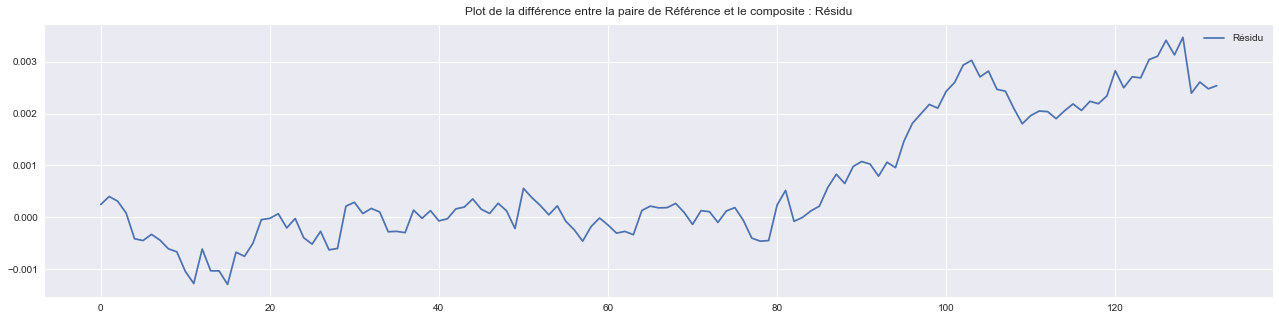

In [38]:
bt_combo = cste + coef[0] * bt_df['AUD/USD'] + coef[1] * bt_df['CHF/USD'] + coef[2] * bt_df['GBP/USD'] + coef[3] * bt_df['JPY/USD']
bt_residu = bt_df['EUR/USD']-bt_combo
bt_S = (bt_residu - bt_residu.mean())/bt_residu.std()
plt.figure(figsize=(22,5))
plt.plot(bt_residu,label = 'Résidu')
plt.title('Plot de la différence entre la paire de Référence et le composite : Résidu')
plt.legend()

 
TEST DE NORMALITE : JARQUE-BERA JPY/USD 
Puisque la p-value ( 0.0 ) de la statistique de Jarque-Bera est inférieure au seuil de signification de 5%, donc on  refuse l’hypothèse de la normalité de la série 
 TEST JARQUE-BERRA VALIDE 
 
TEST D'ASSYMETRIE: SKEWNESS JPY/USD 
Puisque le skewness ( 0.3377 ) de la statistiqest éloigné de 0, donc on valide en niveau 1 une distribution NON NORMALE
 TEST SKEWNESS VALIDE 
 
TEST D'ASSYMETRIE: KURTOSIS JPY/USD 
Puisque le skewness ( -0.3747 ) de la statistiqest éloigné de 3, donc on valide en niveau 2 une distribution NON NORMALE
 TEST DE KURTOSIS VALIDE 
 
CORRELOGRAMME D'AUTOCORRELATION DE LA PAIRE JPY/USD 
JPY/USD :          ACF      PACF       QSTAT           PROB
0  1.000000  1.000000  126.511736   2.375925e-29
1  0.964405  0.971712  247.102285   2.199989e-54
2  0.937993  0.145044  361.286211   5.367338e-78
3  0.909246 -0.034179  469.989373  2.070173e-100
4  0.883737  0.032376  569.941874  6.302940e-121
L'index de sortie de l'intervalle de 

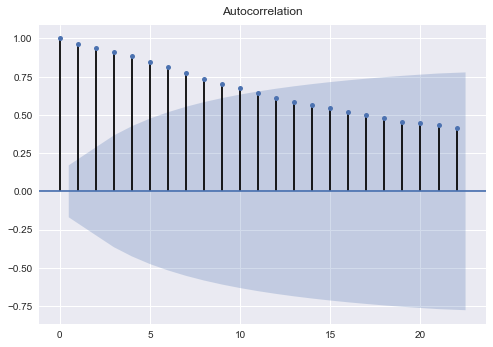

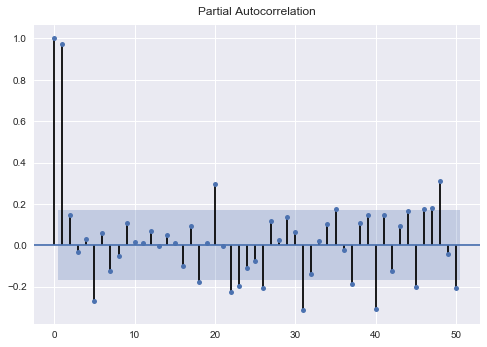

In [39]:
jarque_berra(bt_residu)
skewness(bt_residu)
kurtos(bt_residu)
bt_residu_autocor = pd.DataFrame()
bt_residu_autocor['Close'] = bt_residu.iloc[:]
autocor(bt_residu_autocor)
print("La moyenne des résidus est de ",bt_residu.mean(),", et leur ecart-type vaut ",bt_residu.std())

In [40]:
bt_model = sm.OLS(bt_residu,bt_residu.index)
bt_results = bt_model.fit()
bt_residuals = bt_results.resid
bt_summary = bt_results.summary()
name = 'Analyse des Résidus'
jb,p_value,skew,kurtosis,durbinwatson = ols(bt_model,bt_results, bt_residuals)

Analyse des Résidus :                                   OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.635
Model:                            OLS   Adj. R-squared (uncentered):              0.632
Method:                 Least Squares   F-statistic:                              229.3
Date:                Fri, 28 Feb 2020   Prob (F-statistic):                    1.20e-30
Time:                        13:14:10   Log-Likelihood:                          753.47
No. Observations:                 133   AIC:                                     -1505.
Df Residuals:                     132   BIC:                                     -1502.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

 
CORRELOGRAMME D'AUTOCORRELATION DE LA PAIRE Analyse des Résidus 
Analyse des Résidus :          ACF      PACF       QSTAT           PROB
0  1.000000  1.000000  126.511736   2.375925e-29
1  0.964405  0.971712  247.102285   2.199989e-54
2  0.937993  0.145044  361.286211   5.367338e-78
3  0.909246 -0.034179  469.989373  2.070173e-100
4  0.883737  0.032376  569.941874  6.302940e-121
L'index de sortie de l'intervalle de confiance à 5% est de 11 . Il apparait donc clairement que la série n'est pas un bruit blanc
 TEST AUTOCORRELATION VALIDE 


()

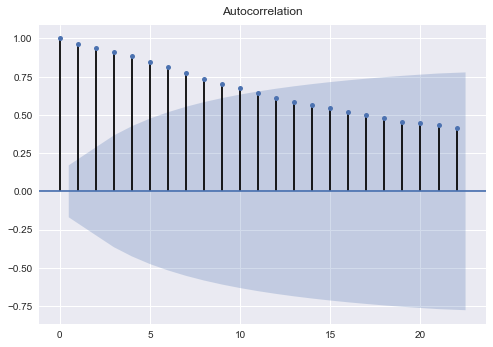

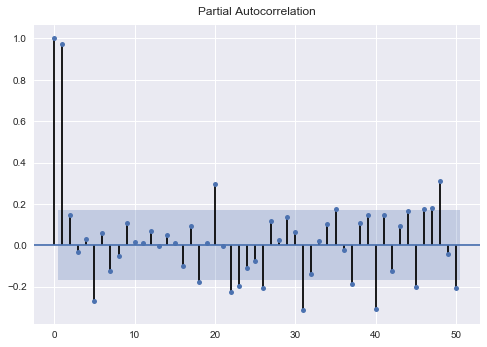

In [41]:
temp = pd.DataFrame()
temp['Close'] = bt_residu.iloc[:]
autocor(temp)

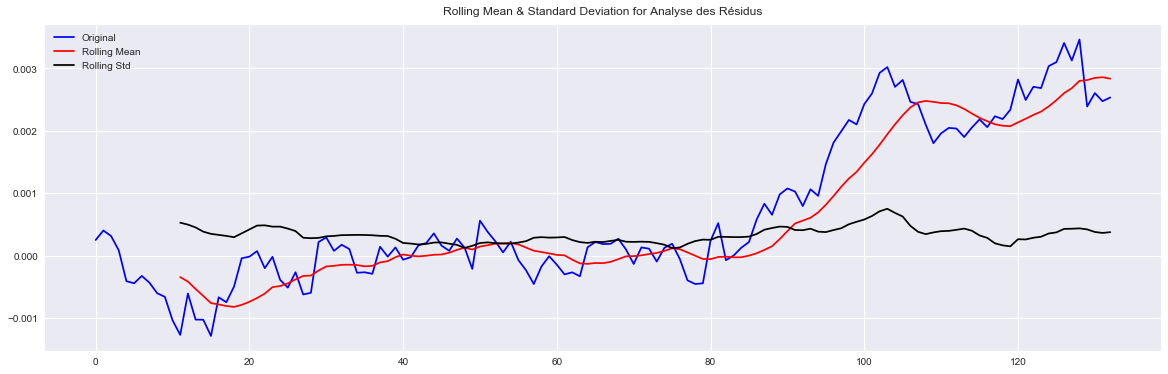

Results of Dickey-Fuller Test pour la paire : Analyse des Résidus
Test Statistic                  -0.609757
p-value                          0.868762
#Lags Used                       1.000000
Number of Observations Used    131.000000
Critical Value (1%)             -3.481282
Critical Value (5%)             -2.883868
Critical Value (10%)            -2.578677
dtype: float64
Le test est   NON VALIDE  et le résidu  :   NON STATIONNAIRE 


In [42]:
dfoutput =  test_stationarity(bt_residu,lag = 1)
if dfoutput[1] < 0.05 and dfoutput[0] < dfoutput[6]:
    print('Le test est ',Fore.GREEN,'VALIDE',Style.RESET_ALL,'et le résidu est : ',Fore.GREEN,'STATIONNAIRE',Style.RESET_ALL)
else:
    print('Le test est ',Fore.RED,'NON VALIDE',Style.RESET_ALL,'et le résidu  : ',Fore.RED,'NON STATIONNAIRE',Style.RESET_ALL)


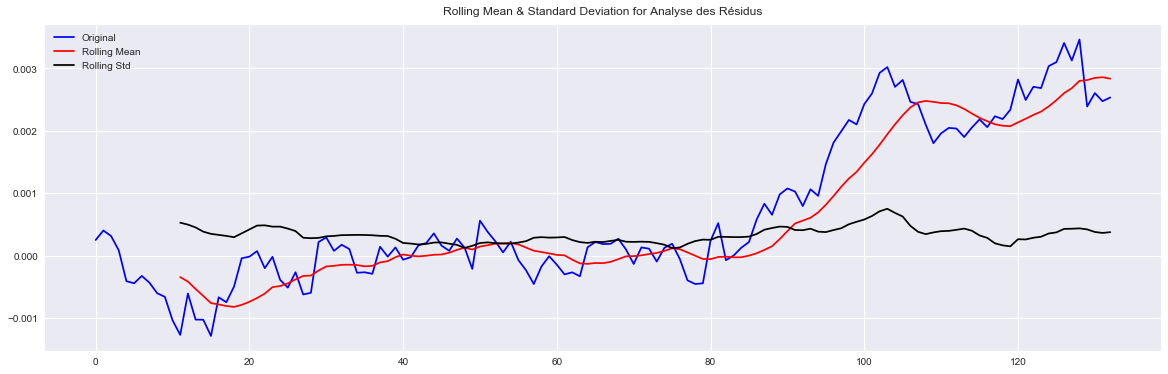

Results of Dickey-Fuller Test pour la paire : Analyse des Résidus
Test Statistic                  -0.893341
p-value                          0.790157
#Lags Used                       0.000000
Number of Observations Used    132.000000
Critical Value (1%)             -3.480888
Critical Value (5%)             -2.883697
Critical Value (10%)            -2.578586
dtype: float64
Le test est   NON VALIDE  et il n'y a   PAS RETOUR A LA MOYENNE 


In [43]:
#######
### RETOUR A LA MOYENNE
#######
dfoutput =  test_stationarity(bt_residu,lag = 0)
if dfoutput[1] < 0.05 and dfoutput[0] < dfoutput[6]:
    print('Le test est ',Fore.GREEN,'VALIDE',Style.RESET_ALL,'et il y a : ',Fore.GREEN,'RETOUR A LA MOYENNE',Style.RESET_ALL)
else:
    print('Le test est ',Fore.RED,'NON VALIDE',Style.RESET_ALL,"et il n'y a ",Fore.RED,'PAS RETOUR A LA MOYENNE',Style.RESET_ALL)

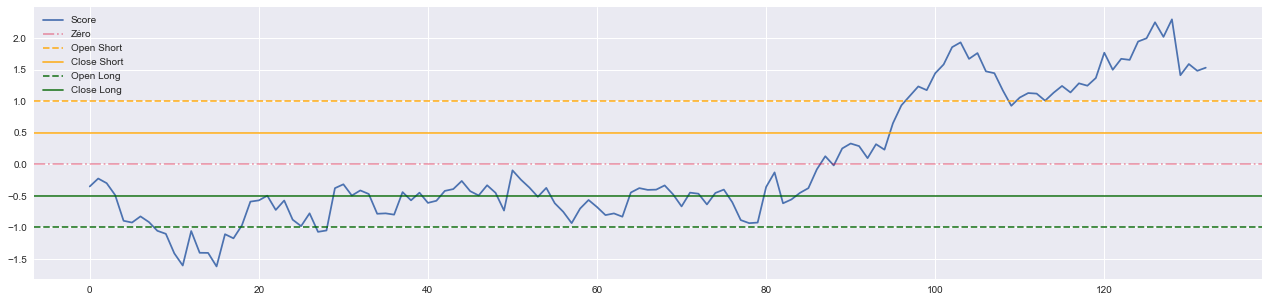

In [44]:
plt.figure(figsize=(22,5))
plt.plot(bt_S,label='Score')
plt.axhline(y=0,c='crimson',alpha=0.4,linestyle='-.',label='Zéro')
plt.axhline(y=1,c='orange',alpha=0.8,linestyle='--',label='Open Short')
plt.axhline(y=0.5,c='orange',alpha=0.8,label ='Close Short')
plt.axhline(y=-1,c='darkgreen',alpha=0.8,linestyle='--', label='Open Long')
plt.axhline(y=-0.5,c='darkgreen',alpha=0.8,label='Close Long')
plt.legend()

In [45]:
backtest_df = pd.DataFrame()
backtest_df = bt_df
backtest_df.index = bt_pair['Local time']
backtest_df['Spread'] = bt_residu.to_list()
backtest_df['Signals'] = bt_S.to_list()
backtest_df.tail()

,EUR/USD,AUD/USD,CHF/USD,GBP/USD,JPY/USD,Spread,Signals
Local time,,,,,,,
26.02.2020 19:35:00.000 GMT+0100,1.08874,0.65531,1.023678,1.29106,0.009070,0.003465,2.294597
26.02.2020 19:40:00.000 GMT+0100,1.08891,0.65546,1.024653,1.29097,0.009075,0.002390,1.410251
26.02.2020 19:45:00.000 GMT+0100,1.08777,0.65531,1.023541,1.29017,0.009062,0.002606,1.587451
26.02.2020 19:50:00.000 GMT+0100,1.08795,0.65534,1.023814,1.29074,0.009068,0.002475,1.480187
26.02.2020 19:55:00.000 GMT+0100,1.08814,0.65523,1.023929,1.29027,0.009067,0.002535,1.529404




Date :  26.02.2020 09:35:00.000 GMT+0100
 ACTION OPEN LONG  - 
close EUR/USA  1.08807 
close AUD/USD :  0.65775 
Close CHF/USD :  1.0259672306066545 
Close GBP/USD :  1.29826 
Close JPY/USD :  0.009060350997997662


Date :  26.02.2020 10:40:00.000 GMT+0100
 ACTION CLOSE LONG  - 
close EUR/USA  1.0887799999999999 
close AUD/USD :  0.6575 
Close CHF/USD :  1.0259988098413806  
Close GBP/USD :  1.2948 
Close JPY/USD :  0.009064786025725862
pnl EUR/USd : 70.9999999999709 
pnl au : 6.654447152144712 
pnl ch : -3.962740074886824 
pnl gp -8.25923956628776 
pnl jp : 2.117301777882858 
total combo :  -3.4502307111470145 
pnl total : 67.54976928882388


Profit en Long : 67.54976928882388
Profit en Short :  0


Date :  26.02.2020 11:10:00.000 GMT+0100
 ACTION OPEN LONG  - 
close EUR/USA  1.08791 
close AUD/USD :  0.65754 
Close CHF/USD :  1.0257988408473098 
Close GBP/USD :  1.29379 
Close JPY/USD :  0.009056084330257284


Date :  26.02.2020 11:20:00.000 GMT+0100
 ACTION CLOSE LONG  - 
close EU

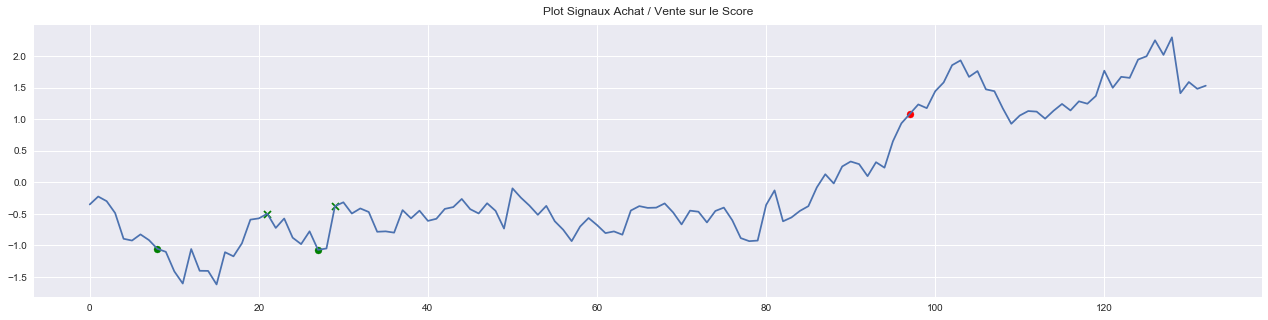

In [46]:
plt.figure(figsize=(22,5))
_plot = plt.plot(bt_S,label = 'Score')
os,cs,ol,cl = 0,0,0,0

mise = 100000
pactol = 100000
profit_long = 0
profit_short = 0
profit = 0
nbre_trade = 0
nbre_trade_long = 0
nbre_trade_short = 0
pnls = 0
pnll = 0

for mark in range(0,len(backtest_df)):
    if backtest_df.iloc[mark]['Signals'] > 1 and os == 0:
        _os = scatter =  plt.scatter(x=mark,y=bt_S[mark],c='r',marker='o',label='Open Short')
        os = 1
        cs = 0
        #pactol = pactol + mise * backtest_df.iloc[mark]['EUR/USD']
        #pactol = pactol - mise * (coef[0] * backtest_df.iloc[mark]['AUD/USD'] + coef[1] * backtest_df.iloc[mark]['CHF/USD'] +\
                                 #coef[2] * backtest_df.iloc[mark]['GBP/USD'] + coef[3] * backtest_df.iloc[mark]['JPY/USD'])
        eos = mise * backtest_df.iloc[mark]['EUR/USD']
        auos = -  mise * coef[0] * backtest_df.iloc[mark]['AUD/USD']
        chos = - mise * coef[1] * backtest_df.iloc[mark]['CHF/USD']
        gbos = - mise * coef[2] * backtest_df.iloc[mark]['GBP/USD']
        jpos = - mise * coef[3] * backtest_df.iloc[mark]['JPY/USD']
        
        
        print('\n\nDate : ',backtest_df.index[mark])
        print(Fore.GREEN,'ACTION OPEN SHORT',Style.RESET_ALL,\
              '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
              '\nClose CHF/USD : ',backtest_df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
             '\nClose JPY/USD : ',backtest_df.iloc[mark]['JPY/USD'])  
    
    if backtest_df.iloc[mark]['Signals'] < 0.5 and os == 1:
        _cs = scatter = plt.scatter(x=mark,y=bt_S[mark],c='r',marker='x',label='Close Short : ')
        os = 0
        cs = 1
        #pactol = pactol - mise * backtest_df.iloc[mark]['EUR/USD']
        #pactol = pactol + mise * (coef[0] * backtest_df.iloc[mark]['AUD/USD'] + coef[1] * backtest_df.iloc[mark]['CHF/USD'] +\
                                 #coef[2] * backtest_df.iloc[mark]['GBP/USD'] + coef[3] * backtest_df.iloc[mark]['JPY/USD'])
        print('\n\nDate : ',backtest_df.index[mark])
        print(Fore.RED,'ACTION CLOSE SHORT',Style.RESET_ALL,\
              '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
              '\nClose CHF/USD : ',backtest_df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
             '\nClose JPY/USD : ',backtest_df.iloc[mark]['JPY/USD']) 
        
        #e = e - mise * backtest_df.iloc[mark]['EUR/USD']
        #au = au + mise * coef[0] * backtest_df.iloc[mark]['AUD/USD']
        #ch = (ch +  mise * coef[1] * backtest_df.iloc[mark]['CHF/USD']) / backtest_df.iloc[mark]['CHF/USD']
        #gb = gb + mise * coef[2] * backtest_df.iloc[mark]['GBP/USD']
        #jp = (jp + mise * coef[3] * backtest_df.iloc[mark]['JPY/USD']) / backtest_df.iloc[mark]['JPY/USD']
        
        ecs = - mise * backtest_df.iloc[mark]['EUR/USD']
        aucs = mise * coef[0] * backtest_df.iloc[mark]['AUD/USD']
        chcs = mise * coef[1] * backtest_df.iloc[mark]['CHF/USD']
        gbcs = mise * coef[2] * backtest_df.iloc[mark]['GBP/USD']
        jpcs = mise * coef[3] * backtest_df.iloc[mark]['JPY/USD']
        
        pnles = eos + ecs
        pnlaus = auos + aucs
        pnlchs = (chos + chcs) 
        pnlgbs = gbos + gbcs
        pnljps = (jpos + jpcs) 
        pnlcombos = pnlaus + pnlchs + pnlgbs + pnljps
        pnls = pnles + pnlcombos
        
        nbre_trade += 1
        nbre_trade_short +=1
        
        profit = profit + pnls
        
        print('pnl EUR/USd :',pnles,'\npnl au :',pnlaus,'\npnl ch :',pnlchs,'\npnl gp',pnlgbs,'\npnl jp :',pnljps,\
              '\ntotal combo : ',pnlcombos,'\npnl total :',pnls)
        
        
    if backtest_df.iloc[mark]['Signals'] < -1 and ol == 0:
        _ol = scatter = plt.scatter(x=mark,y=bt_S[mark],c='g',marker='o',label='Open Long')
        ol = 1
        os = 0
        #pactol = pactol - mise * backtest_df.iloc[mark]['EUR/USD']
        #pactol = pactol + mise * (coef[0] * backtest_df.iloc[mark]['AUD/USD'] + coef[1] * backtest_df.iloc[mark]['CHF/USD'] +\
        #                         coef[2] * backtest_df.iloc[mark]['GBP/USD'] + coef[3] * backtest_df.iloc[mark]['JPY/USD'])
        print('\n\nDate : ',backtest_df.index[mark])
        print(Fore.GREEN,'ACTION OPEN LONG',Style.RESET_ALL,\
              '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
              '\nClose CHF/USD : ',backtest_df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
             '\nClose JPY/USD : ',backtest_df.iloc[mark]['JPY/USD'])
        
        eol = - mise * backtest_df.iloc[mark]['EUR/USD']
        auol = mise * coef[0] * backtest_df.iloc[mark]['AUD/USD']
        chol = mise * coef[1] * backtest_df.iloc[mark]['CHF/USD']
        gbol = mise * coef[2] * backtest_df.iloc[mark]['GBP/USD']
        jpol = mise * coef[3] * backtest_df.iloc[mark]['JPY/USD']
        
        
        
    if backtest_df.iloc[mark]['Signals'] > -0.5 and ol == 1 :
        _cl = scatter = plt.scatter(x=mark,y=bt_S[mark],c='g',marker='x',label='Close Long')
        ol = 0
        cl = 1
        #pactol = pactol + mise * backtest_df.iloc[mark]['EUR/USD']
        #pactol = pactol - mise * (coef[0] * backtest_df.iloc[mark]['AUD/USD'] + coef[1] * backtest_df.iloc[mark]['CHF/USD'] +\
        #                         coef[2] * backtest_df.iloc[mark]['GBP/USD'] + coef[3] * backtest_df.iloc[mark]['JPY/USD'])
        
        print('\n\nDate : ',backtest_df.index[mark])
        print(Fore.RED,'ACTION CLOSE LONG',Style.RESET_ALL,\
              '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
              '\nClose CHF/USD : ',backtest_df.iloc[mark]['CHF/USD'],' \nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
             '\nClose JPY/USD : ',backtest_df.iloc[mark]['JPY/USD'])
        
        ecl = mise * backtest_df.iloc[mark]['EUR/USD']
        aucl = -  mise * coef[0] * backtest_df.iloc[mark]['AUD/USD']
        chcl = - mise * coef[1] * backtest_df.iloc[mark]['CHF/USD']
        gbcl = - mise * coef[2] * backtest_df.iloc[mark]['GBP/USD']
        jpcl = - mise * coef[3] * backtest_df.iloc[mark]['JPY/USD']
        
        pnlel = eol + ecl
        pnlaul = auol + aucl
        pnlchl = (chol + chcl) 
        pnlgbl = gbol + gbcl
        pnljpl = (jpol + jpcl) 
        pnlcombol = pnlaul + pnlchl + pnlgbl + pnljpl
        pnll = pnlel + pnlcombol
        
        nbre_trade += 1
        nbre_trade_long +=1
        
        profit = profit + pnll
        
        print('pnl EUR/USd :',pnlel,'\npnl au :',pnlaul,'\npnl ch :',pnlchl,'\npnl gp',pnlgbl,'\npnl jp :',pnljpl,\
              '\ntotal combo : ',pnlcombol,'\npnl total :',pnll)
        
        print('\n\nProfit en Long :',pnll)
        print('Profit en Short : ',pnls)


    
plt.title('Plot Signaux Achat / Vente sur le Score')
#plt.legend((_os,_cs,_ol,_cl),('Open Short','Close Short','Open Long','Close Long'),scatterpoints=1 )

'''if ol == 1:
    pactol = pactol - qty * backtest_df.iloc[mark]['EUR/USD']
    pactol = pactol + qty * (coef[0] * backtest_df.iloc[mark]['AUD/USD'] + coef[1] * backtest_df.iloc[mark]['CHF/USD'] +\
                             coef[2] * backtest_df.iloc[mark]['GBP/USD'] + coef[3] * backtest_df.iloc[mark]['JPY/USD']) 
    
if os == 1:
    pactol = pactol + qty * backtest_df.iloc[mark]['EUR/USD']
    pactol = pactol - qty * (coef[0] * backtest_df.iloc[mark]['AUD/USD'] + coef[1] * backtest_df.iloc[mark]['CHF/USD'] +\
                             coef[2] * backtest_df.iloc[mark]['GBP/USD'] + coef[3] * backtest_df.iloc[mark]['JPY/USD'])'''
    
print(Fore.YELLOW,'------------------------------------------------------------------------')
print(' --------------------------------RESULTATS--------------------------------')
print(' ------------------------------------------------------------------------',Style.RESET_ALL)
if profit < 0:
    print('Le profit généré en $',Fore.RED,round(profit,2),Style.RESET_ALL)
    

if profit > 0:
    print('Le profit généré en $',Fore.GREEN,round(profit,2),Style.RESET_ALL)

print('Nombre de trades long : ',nbre_trade_long)
print('Nombre de trades short : ',nbre_trade_short)
    

In [49]:
debut, split, fin

('17.02.2020 00:00:00.000 GMT+0100',
 '26.02.2020 08:55:00',
 '28.02.2020 11:55:00')

In [48]:
coef[0],coef[1],coef[2],coef[3]

(0.2661778860857056,
 1.25485627161679,
 -0.023870634584646885,
 -4.77404405934131)